# Regression with Amazon SageMaker XGBoost algorithm


In [ ]:
# ensure sagemaker version >= 1.65.1
! pip install -qU awscli boto3 sagemaker
! pip install shap

In [ ]:
import os
import boto3
import re
import sagemaker

# Get a SageMaker-compatible role used by this Notebook Instance.
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### update below values appropriately ###
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dist-script'
#### 

print(region)

### Fetching the dataset

Following methods split the data into train/test/validation datasets and upload files to S3.

In [ ]:
import io
import random

def data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_BASE, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, 
               PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST):
    data = [l for l in open(FILE_DATA, 'r')]
    train_file_0 = open(DATA_DIR + "/" + FILE_TRAIN_0, 'w')
    train_file_1 = open(DATA_DIR + "/" + FILE_TRAIN_1, 'w')
    valid_file = open(DATA_DIR + "/" + FILE_VALIDATION, 'w')
    tests_file = open(DATA_DIR + "/" + FILE_TEST, 'w')

    num_of_data = len(data)
    num_train_0 = int((PERCENT_TRAIN_0/100.0)*num_of_data)
    num_train_1 = int((PERCENT_TRAIN_1/100.0)*num_of_data)
    num_valid = int((PERCENT_VALIDATION/100.0)*num_of_data)
    num_tests = int((PERCENT_TEST/100.0)*num_of_data)

    data_fractions = [num_train_0, num_train_1, num_valid, num_tests]
    split_data = [[],[],[],[]]

    rand_data_ind = 0

    for split_ind, fraction in enumerate(data_fractions):
        for i in range(fraction):
            rand_data_ind = random.randint(0, len(data)-1)
            split_data[split_ind].append(data[rand_data_ind])
            data.pop(rand_data_ind)

    for l in split_data[0]:
        train_file_0.write(l)

    for l in split_data[1]:
        train_file_1.write(l)
        
    for l in split_data[2]:
        valid_file.write(l)

    for l in split_data[3]:
        tests_file.write(l)

    train_file_0.close()
    train_file_1.close()
    valid_file.close()
    tests_file.close()

def write_to_s3(fobj, bucket, key):
    return boto3.Session(region_name=region).resource('s3').Bucket(bucket).Object(key).upload_fileobj(fobj)

def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

### Upload data to Amazon S3


In [ ]:

import urllib.request

# Load the dataset
FILE_DATA = 'abalone'
urllib.request.urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone", FILE_DATA)

#split the downloaded data into train/test/validation files
FILE_TRAIN_0 = 'abalone.train_0'
FILE_TRAIN_1 = 'abalone.train_1'
FILE_VALIDATION = 'abalone.validation'
FILE_TEST = 'abalone.test'
PERCENT_TRAIN_0 = 35
PERCENT_TRAIN_1 = 35
PERCENT_VALIDATION = 15
PERCENT_TEST = 15

DATA_DIR = 'data'

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

data_split(FILE_DATA, DATA_DIR, FILE_TRAIN_0, FILE_TRAIN_1, FILE_VALIDATION, FILE_TEST, 
           PERCENT_TRAIN_0, PERCENT_TRAIN_1, PERCENT_VALIDATION, PERCENT_TEST)


In [ ]:
#upload the files to the S3 bucket
upload_to_s3(bucket, 'train/train_0.libsvm', DATA_DIR + "/" + FILE_TRAIN_0)
upload_to_s3(bucket, 'train/train_1.libsvm', DATA_DIR + "/" + FILE_TRAIN_1)
upload_to_s3(bucket, 'validation/validation.libsvm', DATA_DIR + "/" + FILE_VALIDATION)
upload_to_s3(bucket, 'test/test.libsvm', DATA_DIR + "/" + FILE_TEST)

## Training the XGBoost model

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between few minutes.

To run our training script on SageMaker, we construct a sagemaker.xgboost.estimator.XGBoost estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

In [17]:
from sagemaker.session import s3_input, Session
sage_client = boto3.Session().client('sagemaker')
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())

hyperparams = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "verbose":"1",
        "objective":"reg:linear",
        "num_round":"50",
        "s3_bucket": sagemaker_session.default_bucket()}

instance_type = "ml.m5.2xlarge"
output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'abalone-dist-xgb')
content_type = "libsvm"

In [18]:
# Open Source distributed script mode

from sagemaker.xgboost.estimator import XGBoost

xgb_script_mode_estimator = XGBoost(
    entry_point='train.py',
    framework_version='1.0-1', # Note: framework_version is mandatory
    hyperparameters=hyperparams,
    role=role,
    train_instance_count=2, 
    train_instance_type=instance_type)

train_input = s3_input("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type=content_type)
validation_input = s3_input("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type=content_type)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


### Train XGBoost Estimator on abalone data 


Training is as simple as calling `fit` on the Estimator. This will start a SageMaker Training job that will download the data, invoke the entry point code (in the provided script file), and save any model artifacts that the script creates.

In [ ]:
xgb_script_mode_estimator.fit({'train': train_input, 'validation': validation_input})

### Define HyperParameter Tuner

In [20]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter 

tuner = HyperparameterTuner(estimator=xgb_script_mode_estimator,  
                               objective_metric_name='validation:rmse',
                               hyperparameter_ranges={
                                    'num_round': IntegerParameter(5,30),
                                    'gamma': IntegerParameter(2, 6) },
                               max_jobs=4,
                               max_parallel_jobs=1,
                               objective_type='Minimize')

In [21]:
tuner.fit({'train': train_input, 'validation': validation_input})

### Analyze debugging data

In [22]:
tuning_job_name = tuner.latest_tuning_job.job_name
tuning_job_name

'sagemaker-xgboost-200730-1714'

S3 paths where debugging data of tuning jobs are located:

In [41]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

4 training jobs have completed


In [57]:
s3_paths = []
tuning_jobs = []
for training_job in sage_client.list_training_jobs_for_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)['TrainingJobSummaries']:
    s3_paths.append("s3://" + sagemaker_session.default_bucket() + "/" + training_job['TrainingJobName'] + "/debug-output")
    tuning_jobs.append(training_job['TrainingJobName'])

Available tensors and the location of their debugging data:

In [ ]:
s3_paths

### Analyze tuning jobs

Plot feature importance for all steps in each tuning job:

[2020-07-30 17:45:16.061 ip-172-16-47-202:27074 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-283429445338/sagemaker-xgboost-200730-1714-004-dc5f61c0/debug-output


Plot data for tuning job  sagemaker-xgboost-200730-1714-004-dc5f61c0 for step 0


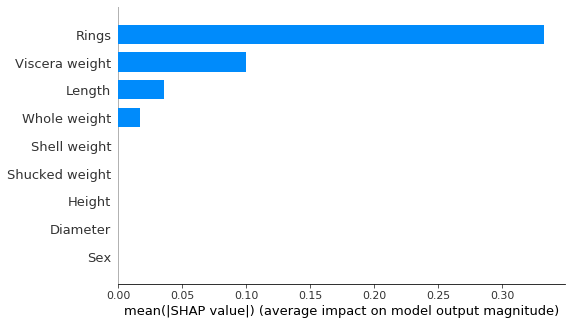



Plot data for tuning job  sagemaker-xgboost-200730-1714-004-dc5f61c0 for step 10


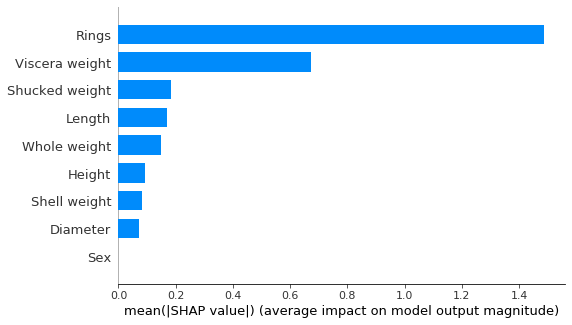



Plot data for tuning job  sagemaker-xgboost-200730-1714-004-dc5f61c0 for step 20


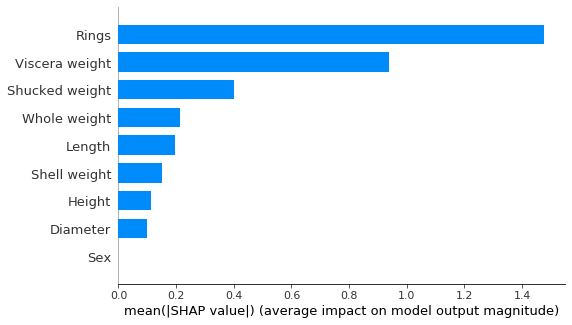

[2020-07-30 17:45:17.055 ip-172-16-47-202:27074 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-283429445338/sagemaker-xgboost-200730-1714-003-cf96557b/debug-output


Plot data for tuning job  sagemaker-xgboost-200730-1714-003-cf96557b for step 0


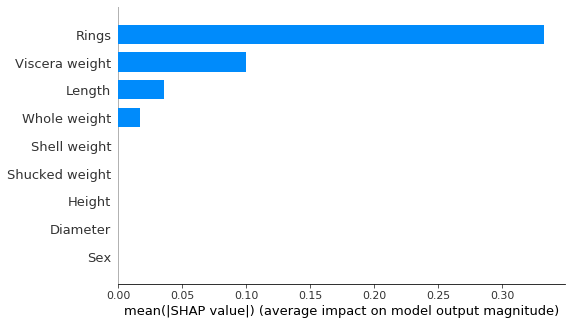



Plot data for tuning job  sagemaker-xgboost-200730-1714-003-cf96557b for step 10


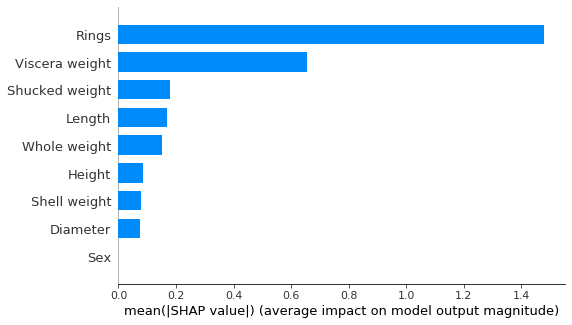

[2020-07-30 17:45:17.652 ip-172-16-47-202:27074 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-283429445338/sagemaker-xgboost-200730-1714-002-2675787d/debug-output


Plot data for tuning job  sagemaker-xgboost-200730-1714-002-2675787d for step 0


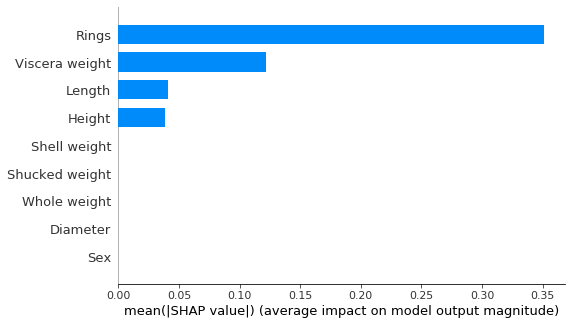



Plot data for tuning job  sagemaker-xgboost-200730-1714-002-2675787d for step 10


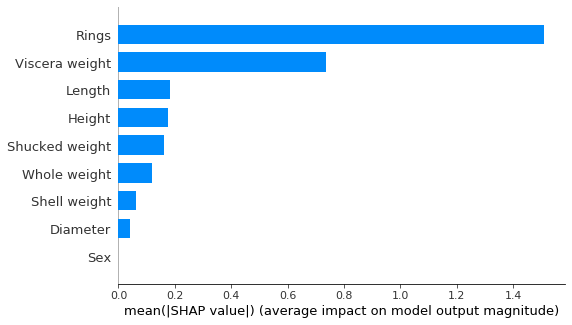



Plot data for tuning job  sagemaker-xgboost-200730-1714-002-2675787d for step 20


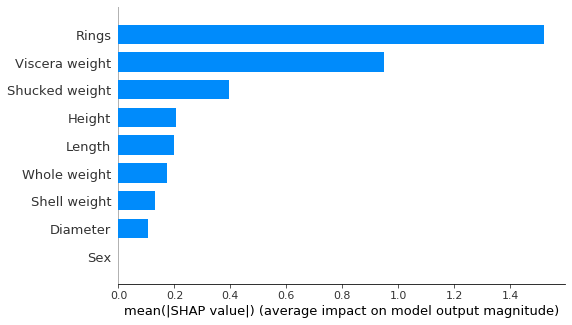

[2020-07-30 17:45:18.432 ip-172-16-47-202:27074 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-west-2-283429445338/sagemaker-xgboost-200730-1714-001-eaa7cb73/debug-output


Plot data for tuning job  sagemaker-xgboost-200730-1714-001-eaa7cb73 for step 0


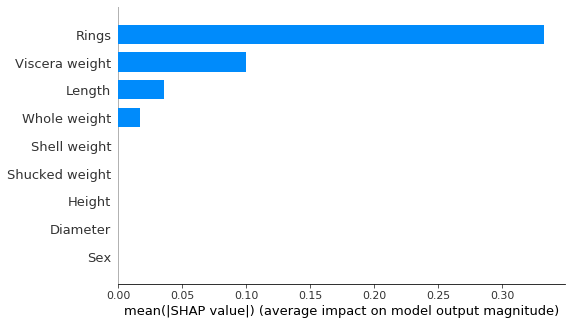



Plot data for tuning job  sagemaker-xgboost-200730-1714-001-eaa7cb73 for step 10


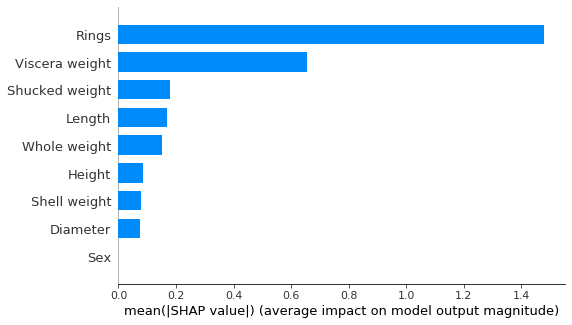



Plot data for tuning job  sagemaker-xgboost-200730-1714-001-eaa7cb73 for step 20


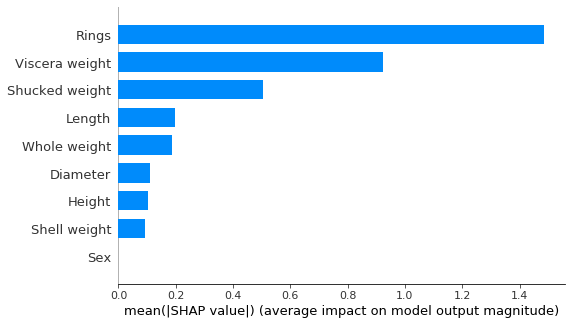

In [60]:
from smdebug.trials import create_trial
import shap
feature_names = ["Sex", "Length", "Diameter", "Height", "Whole weight" , "Shucked weight", "Viscera weight" , "Shell weight" , "Rings"] 
for tuning_job, path in zip(tuning_jobs, s3_paths):
    trial = create_trial(path)

    for step in trial.steps():
        print("\n\nPlot data for tuning job ", tuning_job, "for step", step)
        shap_values = trial.tensor("full_shap/f0").value(step)
        shap_no_base = shap_values[:, :-1]
        shap_base_value = shap_values[0, -1]
        shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)